# Final Assignment
The following script will load data regarding COVID-19-related deaths grouped by vaccination status and age, and briefly visualize and analyze potential differences in death rates given different vaccination status and age groups.
Obtained from the Government of Ontario Data Catalogue, the link to the CSV file can be found on README.md  

## Importing libraries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
import scipy.stats as stats

## Importing data set and understanding
First, we import the CSV file using pandas and explore the contents

In [128]:
# Load the dataset
dataset = pd.read_csv('2aa6e2ce-40de-4910-a737-81762e014b0b.csv')

# Display the first few rows of the dataset
dataset.head()

,_id,date,age_group,deaths_boost_vac_rate_7ma,deaths_full_vac_rate_7ma,deaths_not_full_vac_rate_7ma
0,8858,2021-03-01T00:00:00,0-4yrs,0.0,0.0,0.00
1,8859,2021-03-01T00:00:00,5-11yrs,0.0,0.0,0.00
2,8860,2021-03-01T00:00:00,12-17yrs,0.0,0.0,0.00
3,8861,2021-03-01T00:00:00,18-39yrs,0.0,0.0,0.00
4,8862,2021-03-01T00:00:00,40-59yrs,0.0,0.0,0.02


In [129]:
# Display the length of the dataset
len(dataset)

8892

In [130]:
# Display general information about the dataset and checking for null values
print("\nGeneral info about the dataset:")
print(dataset.info())


General info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8892 entries, 0 to 8891
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   _id                           8892 non-null   int64  
 1   date                          8892 non-null   object 
 2   age_group                     8892 non-null   object 
 3   deaths_boost_vac_rate_7ma     8892 non-null   float64
 4   deaths_full_vac_rate_7ma      8892 non-null   float64
 5   deaths_not_full_vac_rate_7ma  8892 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 416.9+ KB
None


It appears that no null values are present in the data, we can double check that with:

In [131]:
# Check for missing values in the dataset
print("\nMissing values in the dataset:")
print(dataset.isnull().sum())


Missing values in the dataset:
_id                             0
date                            0
age_group                       0
deaths_boost_vac_rate_7ma       0
deaths_full_vac_rate_7ma        0
deaths_not_full_vac_rate_7ma    0
dtype: int64


Now we check the data types, this will be helpful to understand how to use the values stored in every column

In [132]:
# Check the column names and data types
print("\nColumn names and data types:")
print(dataset.dtypes)


Column names and data types:
_id                               int64
date                             object
age_group                        object
deaths_boost_vac_rate_7ma       float64
deaths_full_vac_rate_7ma        float64
deaths_not_full_vac_rate_7ma    float64
dtype: object


Now we convert the date column to datetime variable and rename the categories for more clarity

In [136]:
# Convert the 'date' column to datetime
dataset['date'] = pd.to_datetime(dataset['date'])
# Rename the columns 
dataset = dataset.rename(columns={
    'deaths_boost_vac_rate_7ma': 'Vaccinated & at least 1 Booster',
    'deaths_full_vac_rate_7ma': 'Fully Vaccinated',
    'deaths_not_full_vac_rate_7ma': 'Not Fully Vaccinated'
})

Summary statistics are helpful in understanding central tendency and dispersion of the data in the columns

In [137]:
# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(dataset.describe())


Summary statistics for numerical columns:
               _id                           date  \
count   8892.00000                           8892   
mean   13303.50000  2022-11-30 17:25:30.364372480   
min     8858.00000            2021-03-01 00:00:00   
25%    11080.75000            2022-01-12 00:00:00   
50%    13303.50000            2022-11-26 00:00:00   
75%    15526.25000            2023-10-09 00:00:00   
max    17749.00000            2024-11-12 00:00:00   
std     2567.04363                            NaN   

       Vaccinated & at least 1 Booster  Fully Vaccinated  Not Fully Vaccinated  
count                      8892.000000       8892.000000           8892.000000  
mean                          0.024245          0.023695              0.261889  
min                           0.000000          0.000000              0.000000  
25%                           0.000000          0.000000              0.000000  
50%                           0.000000          0.000000              0.00

We can tell right away that there seems to be an important difference between the mean death rates of the non-vaccinated vs the vaccinated group [0.26 -0.024). We will explore this further down bellow

## Data Visualization
Exploring trends and relationships in the data through data visualization

#### First we plot death rates over time grouped by vaccination status

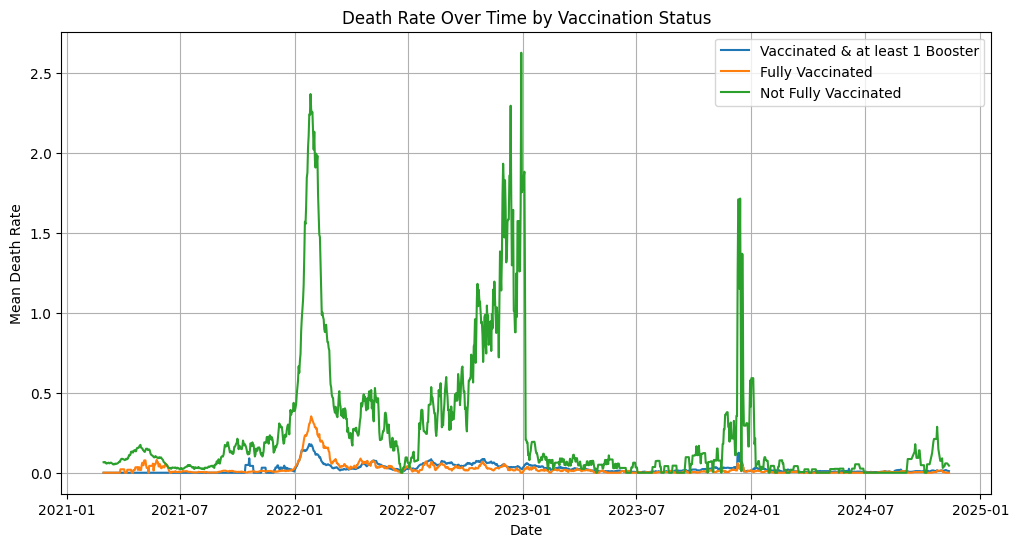

In [140]:
# Group by date and calculate the mean death rate for each vaccination group
time_series = dataset.groupby('date')[['Vaccinated & at least 1 Booster', 'Fully Vaccinated', 'Not Fully Vaccinated']].mean()

# Plot the time series
plt.figure(figsize=(12, 6))
for column in time_series.columns:
    plt.plot(time_series.index, time_series[column], label=column)

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Mean Death Rate")
plt.title("Death Rate Over Time by Vaccination Status")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

We can observe that covid deaths are higher in the non vaccinated group than the vaccinated groups, it also seems like deaths were lower for the booster group than the fully vaccinated group in early 2022, we will explore these differences further down.

#### Now we plot death rate as a function of age, grouped by vaccination status
We will ignore the group without age data "ALL"

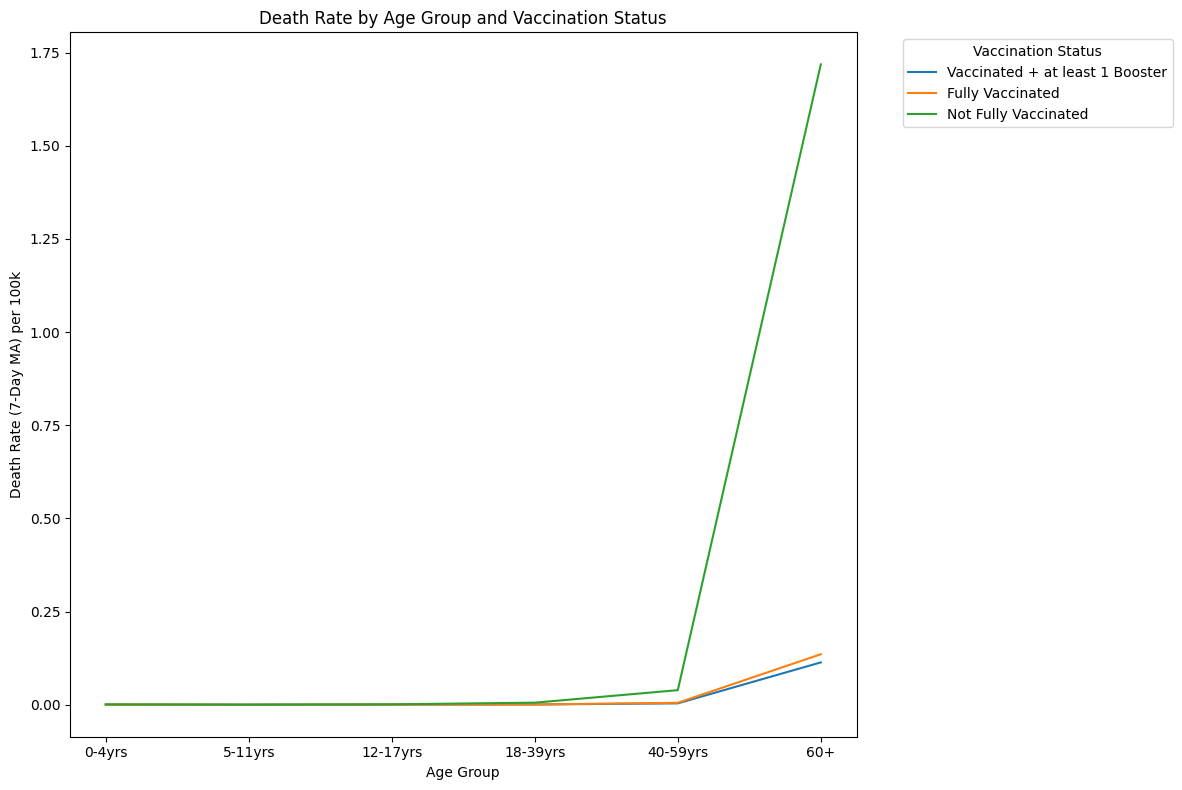

In [96]:
# Filter out the 'ALL' group and sort the age groups by age
age_order = ['0-4yrs', '5-11yrs', '12-17yrs', '18-39yrs', '40-59yrs', '60+']
dataset_filtered = dataset[dataset['age_group'] != 'ALL']

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Plotting the death rate as a function of age group, grouped by vaccination status
for status in ['Vaccinated & at least 1 Booster', 'Fully Vaccinated', 'Not Fully Vaccinated']:
    # Group the data by age group and calculate the mean death rate for each group
    status_data = dataset_filtered.groupby('age_group')[status].mean()
    
    # Ensure age groups are ordered correctly by using the 'age_order' list
    status_data = status_data[age_order]

    # Plotting the data
    plt.plot(status_data.index, status_data, label=status)

# Adding labels and title
plt.title("Death Rate by Age Group and Vaccination Status")
plt.xlabel("Age Group")
plt.ylabel("Death Rate (7-Day MA) per 100k")

# Adjust the legend
plt.legend(title="Vaccination Status", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

We can observe that older age groups have tend to have higher death rates,regardless of vaccination status, specifically in the 60+ age group and a lower death rate overall for vaccinated individuals

#### Now we check the distribution to assess normality 

For simplicity we can use seaborn histplot with a kernel density estimate 


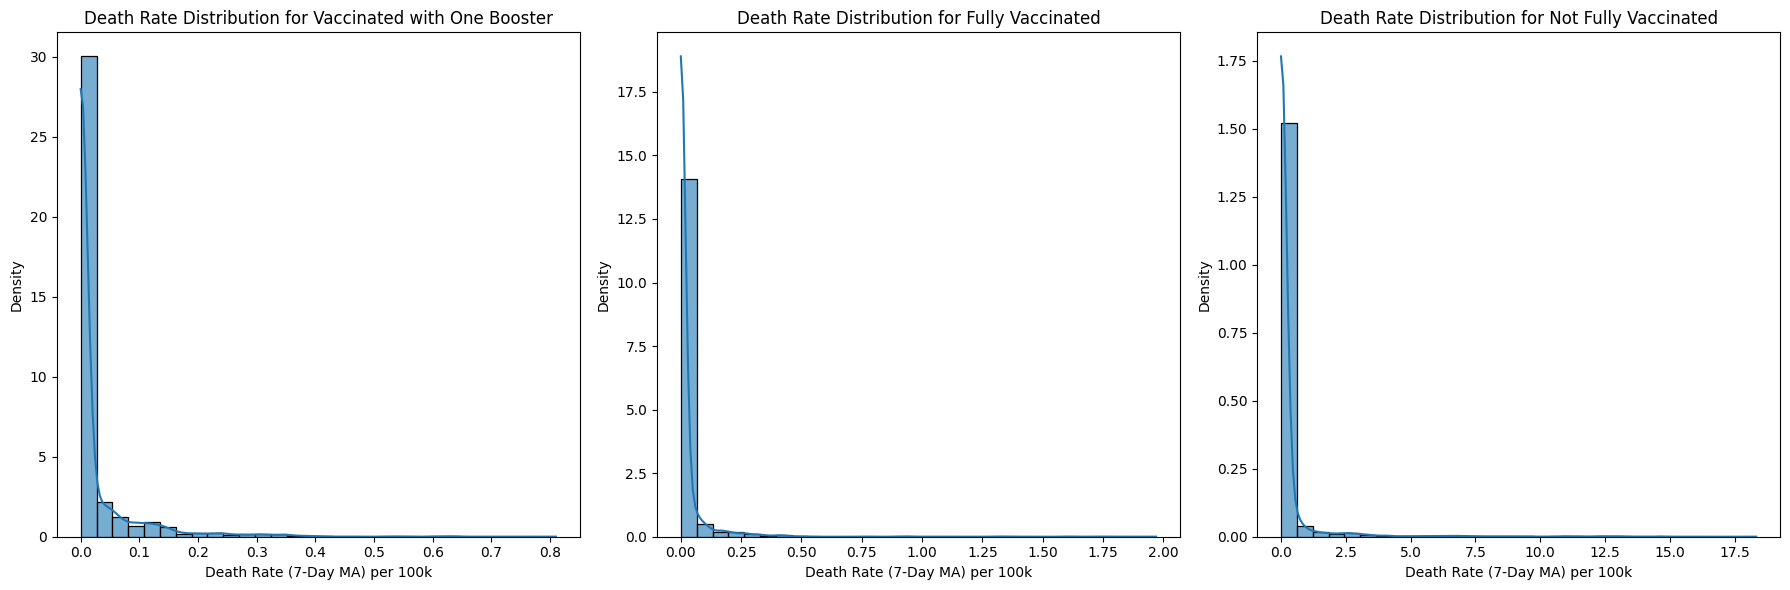

In [76]:
# Create subplots for each vaccination status group
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of vaccination statuses for looping
vaccination_statuses = ['Vaccinated & at least 1 Booster', 'Fully Vaccinated', 'Not Fully Vaccinated']

# Loop through each vaccination status group and plot the histogram and KDE
for i, status in enumerate(vaccination_statuses):
    sns.histplot(dataset_long[dataset_long['vaccination_status'] == status]['death_rate'], 
                 kde=True, 
                 label=status, 
                 bins=30, 
                 stat='density', 
                 alpha=0.6, 
                 ax=axes[i])
    
    # Set titles and labels for each subplot
    axes[i].set_title(f"Death Rate Distribution for {status}")
    axes[i].set_xlabel("Death Rate (7-Day MA) per 100k")
    axes[i].set_ylabel("Density")

# Show the plot
plt.tight_layout()
plt.show()


Distributions seem lightly skewed, with small peaks observed throughout the tail. Non-parametric statistics are likely recommended 

#### Descriptive and inference statistics
We will now estimate and print mean, median, standard deviation and interquartile range of death rates by vaccination status

In [75]:
# Calculate descriptive statistics for each vaccination status group
descriptive_stats = dataset_long.groupby('vaccination_status')['death_rate'].describe()

# Calculate the mean, median, standard deviation for each group
mean_death_rate = dataset_long.groupby('vaccination_status')['death_rate'].mean()
median_death_rate = dataset_long.groupby('vaccination_status')['death_rate'].median()
std_death_rate = dataset_long.groupby('vaccination_status')['death_rate'].std()
# Calculate the ratios
ratio_not_vax_to_fully_vax = mean_death_rate['Not Fully Vaccinated'] / mean_death_rate['Fully Vaccinated']
ratio_not_vax_to_one_booster = mean_death_rate['Not Fully Vaccinated'] / mean_death_rate['Vaccinated & at least 1 Booster']

# Display the results
print("Descriptive Statistics:")
print(descriptive_stats)
print("\nMean Death Rates by Vaccination Status:")
print(mean_death_rate)
print("\nMedian Death Rates by Vaccination Status:")
print(median_death_rate)
print("\nStandard Deviation of Death Rates by Vaccination Status:")
print(std_death_rate)
print(f"Ratio of death rate (Not Fully Vaccinated to Fully Vaccinated): {ratio_not_vax_to_fully_vax:.2f}")
print(f"Ratio of death rate (Not Fully Vaccinated to Vaccinated + at least 1 Booster): {ratio_not_vax_to_one_booster:.2f}")

Descriptive Statistics:
                              count      mean       std  min  25%  50%   75%  \
vaccination_status                                                             
Fully Vaccinated             8892.0  0.023695  0.109072  0.0  0.0  0.0  0.00   
Not Fully Vaccinated         8892.0  0.261889  1.218294  0.0  0.0  0.0  0.03   
Vaccinated with One Booster  8892.0  0.024245  0.067461  0.0  0.0  0.0  0.01   

                               max  
vaccination_status                  
Fully Vaccinated              1.97  
Not Fully Vaccinated         18.33  
Vaccinated with One Booster   0.81  

Mean Death Rates by Vaccination Status:
vaccination_status
Fully Vaccinated               0.023695
Not Fully Vaccinated           0.261889
Vaccinated with One Booster    0.024245
Name: death_rate, dtype: float64

Median Death Rates by Vaccination Status:
vaccination_status
Fully Vaccinated               0.0
Not Fully Vaccinated           0.0
Vaccinated with One Booster    0.0
Name: deat

We can observe that the mean death rates are higher for the non-vaccinated group (~ 11 times higher) relative to vaccinated groups, the median value can't be interpreted since is 0, likely due to the temporal resolution of the data which makes it so that it is zero-inflated. We could solve this by estimating a moving average with a larger temporal window (i.e., monthly moving average). This is not included in this script

#### Preliminary statistical testing
In order to see if the differences observed are statistically significant we can run a statistical test similar

In [72]:
# Kruskal-Wallis test for non-parametric data
kruskal_result = stats.kruskal(
    dataset_long[dataset_long['vaccination_status'] == 'Vaccinated & at least 1 Booster']['death_rate'],
    dataset_long[dataset_long['vaccination_status'] == 'Fully Vaccinated']['death_rate'],
    dataset_long[dataset_long['vaccination_status'] == 'Not Fully Vaccinated']['death_rate']
)

print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")

Kruskal-Wallis Test Results:
Test statistic: 431.78466917600053, p-value: 1.7344045461750875e-94


Given the small p value (p<0.0001), we can make a broad conclusion that the distribution of death rates between vaccination groups is not the same, a proper ad-hoc analysis can include more precise modelling of the relationship between vaccination status and mortality, while controlling for possible confounders (i.e., sex, income, comorbidity, residence, access to healthcare, etc), these confounders are not included in the dataset.

In [138]:
dataset.head()

,_id,date,age_group,Vaccinated & at least 1 Booster,Fully Vaccinated,Not Fully Vaccinated
0,8858,2021-03-01,0-4yrs,0.0,0.0,0.00
1,8859,2021-03-01,5-11yrs,0.0,0.0,0.00
2,8860,2021-03-01,12-17yrs,0.0,0.0,0.00
3,8861,2021-03-01,18-39yrs,0.0,0.0,0.00
4,8862,2021-03-01,40-59yrs,0.0,0.0,0.02
